In [1]:
# pip install scikit-learn scipy pandas matplotlib seaborn ipykernel pingouin fastapi streamlit pydantic uvicorn requests

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_salario = pd.read_csv('./datasets/salarios.csv')
df_salario

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
0,50,1,2288.13
1,49,4,2389.84
2,39,10,2158.73
3,51,1,2341.06
4,62,7,3584.20
...,...,...,...
995,5,10,1037.35
996,7,2,668.01
997,118,6,17511.13
998,94,10,8938.96


In [3]:
df_salario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempo_na_empresa  1000 non-null   int64  
 1   nivel_na_empresa  1000 non-null   int64  
 2   salario_em_reais  1000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


In [4]:
df_salario_eda = df_salario.copy()
df_salario_bucketing = df_salario.copy()


### EDA

In [5]:
df_salario_eda.head(10)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
0,50,1,2288.13
1,49,4,2389.84
2,39,10,2158.73
3,51,1,2341.06
4,62,7,3584.20
5,105,10,12102.18
6,80,3,5723.35
7,85,2,6424.92
8,66,5,3916.18
9,73,5,4751.79


In [6]:
df_salario_eda.describe()

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
count,1000.000000,1000.000000,1000.000000
mean,59.712000,5.467000,5093.726110
std,34.027679,2.889509,4536.168857
min,1.000000,1.000000,538.560000
25%,30.750000,3.000000,1537.477500
50%,60.000000,6.000000,3237.920000
75%,89.000000,8.000000,7436.680000
max,120.000000,10.000000,18923.230000


<Axes: xlabel='tempo_na_empresa'>

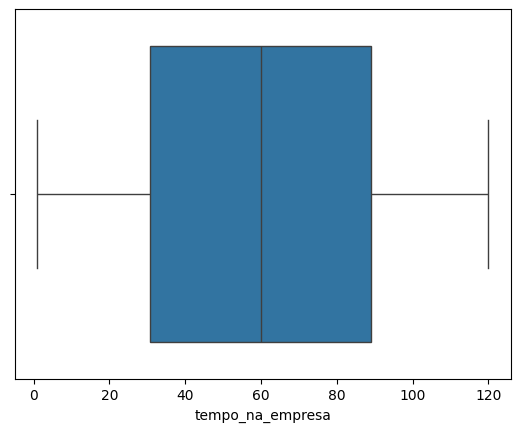

In [7]:
sns.boxplot(data=df_salario_eda, x='tempo_na_empresa')

<Axes: xlabel='salario_em_reais'>

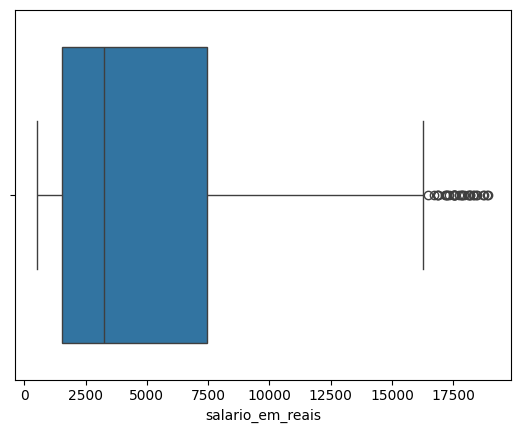

In [8]:
sns.boxplot(data=df_salario_eda, x='salario_em_reais')


<Axes: xlabel='tempo_na_empresa', ylabel='salario_em_reais'>

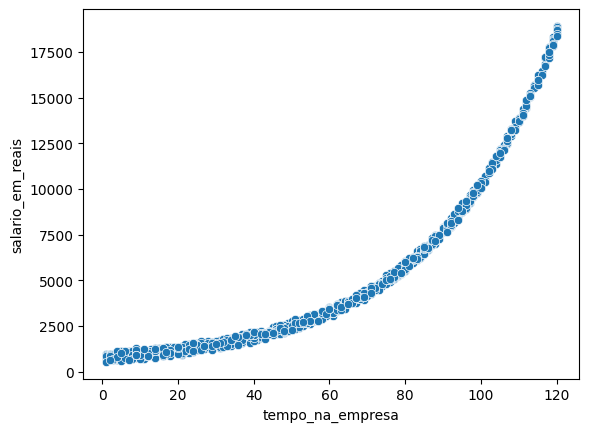

In [9]:
sns.scatterplot(data=df_salario_eda, x='tempo_na_empresa', y='salario_em_reais')

<Axes: xlabel='nivel_na_empresa', ylabel='salario_em_reais'>

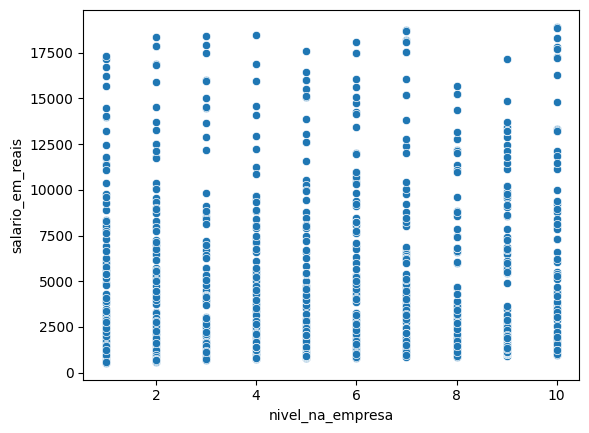

In [10]:
sns.scatterplot(data=df_salario_eda, x='nivel_na_empresa', y='salario_em_reais')

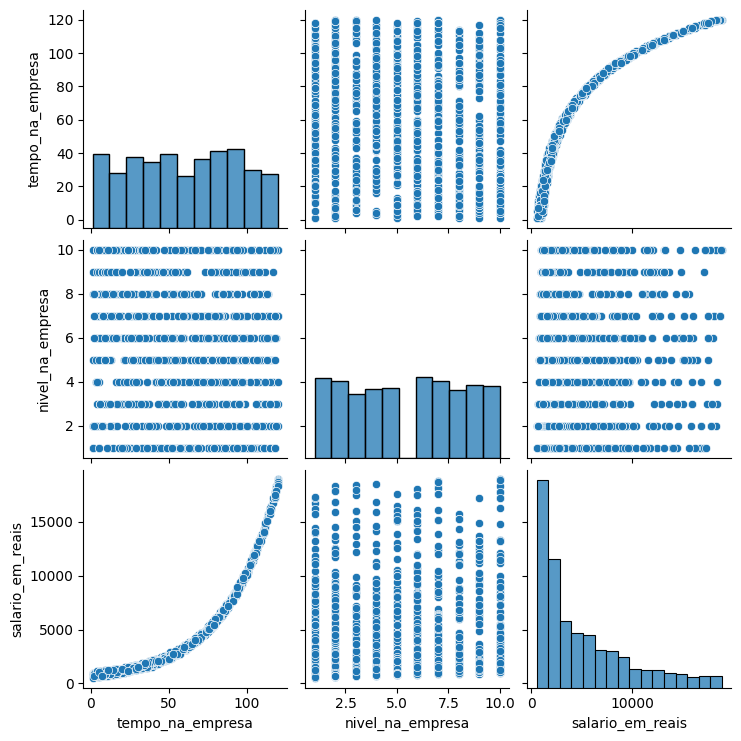

In [11]:
sns.pairplot(df_salario_eda)

<Axes: >

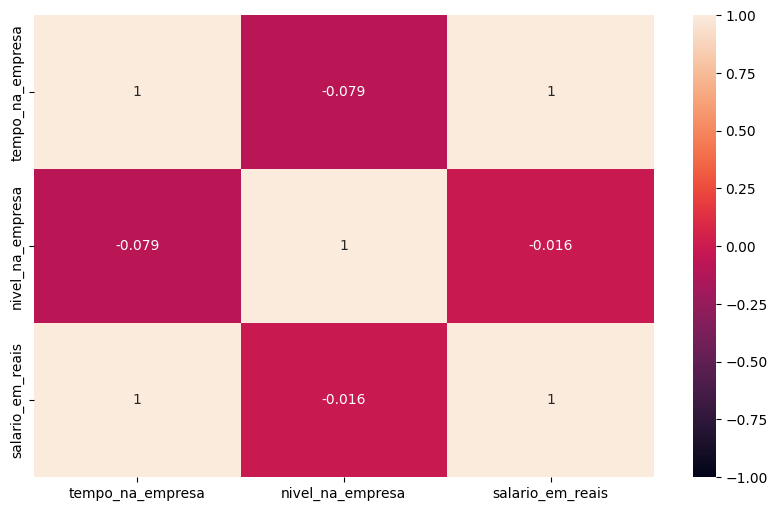

In [12]:
# heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_salario_eda.corr('spearman'), vmin=-1, vmax=1, annot=True)

<Axes: >

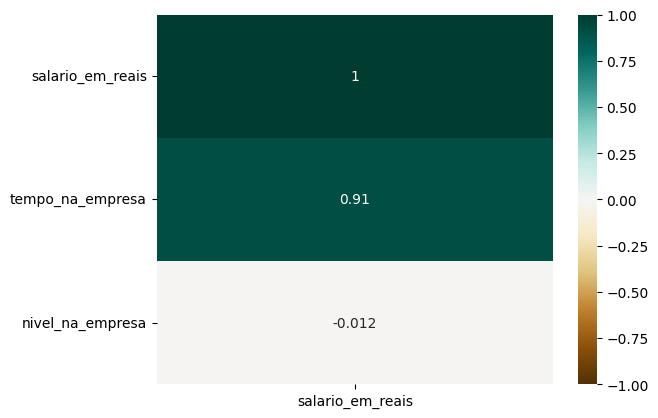

In [13]:
sns.heatmap(df_salario_eda.corr()[['salario_em_reais']].sort_values(by='salario_em_reais', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG' )

In [14]:
#Bucketing tempo de casa
bins_tempo_casa = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130]
labels_tempo_casa = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100-109', '110-119','120-129']

df_salario_bucketing['escala_tempo'] = pd.cut(x=df_salario_bucketing['tempo_na_empresa'], bins=bins_tempo_casa, labels=labels_tempo_casa, include_lowest=True)
df_salario_bucketing.head(10)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais,escala_tempo
0,50,1,2288.13,40-49
1,49,4,2389.84,40-49
2,39,10,2158.73,30-39
3,51,1,2341.06,50-59
4,62,7,3584.20,60-69
5,105,10,12102.18,100-109
6,80,3,5723.35,70-79
7,85,2,6424.92,80-89
8,66,5,3916.18,60-69
9,73,5,4751.79,70-79


<Axes: xlabel='escala_tempo', ylabel='salario_em_reais'>

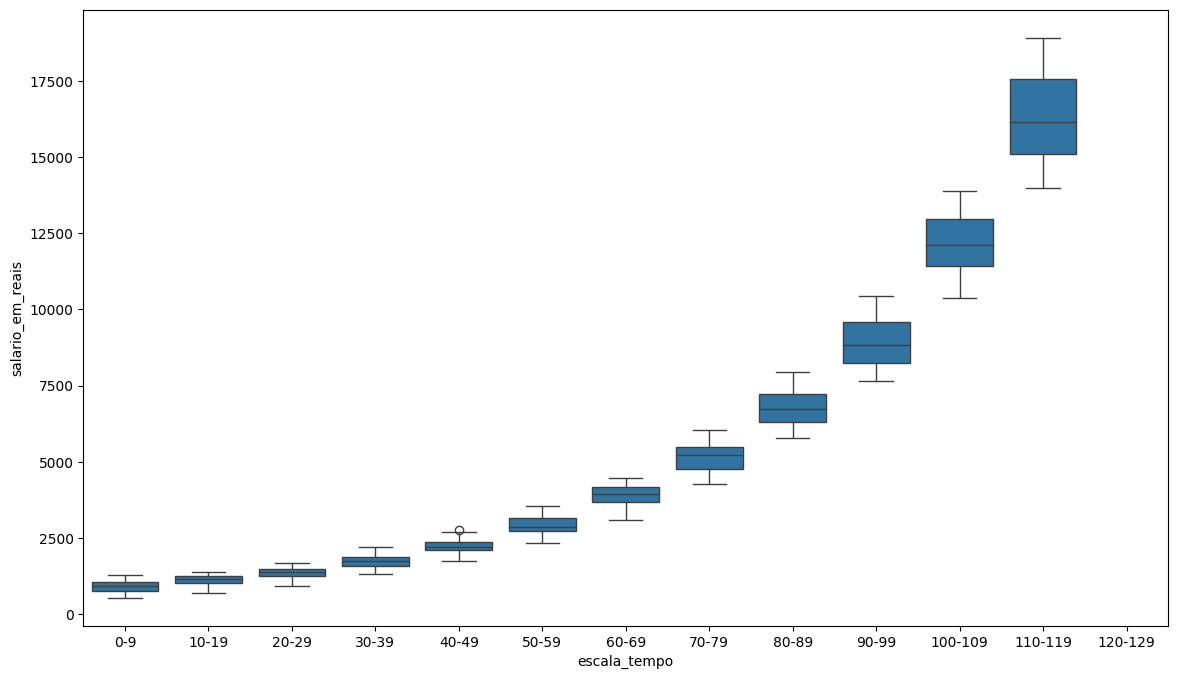

In [15]:
plt.figure(figsize=(14,8))
sns.boxplot(df_salario_bucketing, x='escala_tempo', y='salario_em_reais')

## Treinar modelo linear

In [16]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error

import numpy as np


##### Criar o dataset de treino e teste

In [17]:
X = df_salario.drop(columns='salario_em_reais')
y = df_salario['salario_em_reais']



In [18]:
#Slpit usando o Kfold usando 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=51)


In [23]:
kf.split(X)

<generator object _BaseKFold.split at 0x00000294DFCC3560>

In [44]:
# Bloco para treinamento do modelo

# Pipeline
# Padronização de variáveis numéricas - Tempo na empresa e Nível na empresa
colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']
transformer_numericas = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numericas, colunas_numericas)
    ]
)

#Criando o Pipeline principal que usa o transformer + treinamento
model_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('linear', LinearRegression())
]) 

# Armazenar RMSE Treino 
rmse_scores_fold_train = []
rmse_scores_fold_test = []

# Armazenar R2 score de teste
r2_score_fold_test = []

# Armazenar residuos
residuos = []

# Armazenar predições 
y_pred_total = []

# fazendo as iterações
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #Treinar o modelo no conjunto de treinamentos
    model_reg.fit(X_train, y_train)

    # Faça predições nos conjuntos de treinamento e test
    y_train_pred = model_reg.predict(X_train)
    y_test_pred = model_reg.predict(X_test)

    #Calculo o RMSE do conjunto de treinamento e de teste
    rmse_train = root_mean_squared_error(y_train, y_train_pred)
    rmse_test = root_mean_squared_error(y_test, y_test_pred)
    # Calcular R2 Score e Residuos
    r2_score_test = r2_score(y_test, y_test_pred)
    residuos_test = np.array(y_test - y_test_pred)

    # Adicioanr os valores as listas
    rmse_scores_fold_train.append(rmse_train)
    rmse_scores_fold_test.append(rmse_test)
    r2_score_fold_test.append(r2_score_test)
    residuos.append(residuos_test)
    y_pred_total.append(y_test_pred)


rmse_train_final = np.mean(rmse_scores_fold_train)
rmse_test_final = np.mean(rmse_scores_fold_test)
r2_score_final = np.mean(r2_score_fold_test)

percentual_rmse_final = ((rmse_test_final - rmse_train_final)/rmse_train_final) * 100

residuos = np.array(residuos).reshape(-1)
y_pred_total = np.array(y_pred_total).reshape(-1)



In [46]:
print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Teste: {rmse_test_final}')
print(f'Diferença Percentual RMSE: {percentual_rmse_final}')
print(f'R2 Score Test: {r2_score_final}')


RMSE Treino: 1882.8318426651392
RMSE Teste: 1886.4504221336076
Diferença Percentual RMSE: 0.19218813844503052
R2 Score Test: 0.8261178870584761


# Análise de residuos modelo linear

In [49]:
# Transformar em residuos na escala padrão
# Escala padrão é X - média - Desvio Padrão - Scipy.stats - z-score
from scipy.stats import zscore

residuos_std = zscore(residuos)


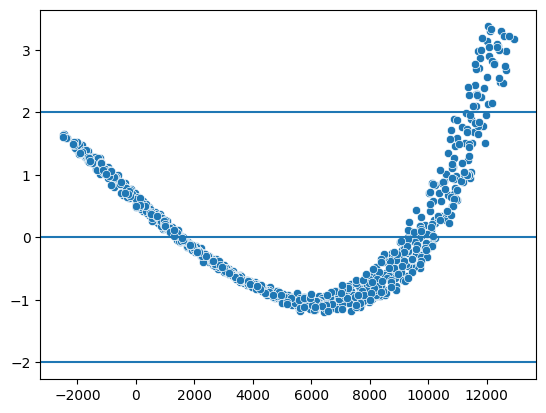

In [51]:
# Checar a Linearidade dos residuos - Valores entre -2 e 2 na escala padrão
# Verificar homocedasticidade - Se valroes estão em torno da reta sem nenhuma tendência ou formato
sns.scatterplot(x=y_pred_total, y=residuos_std)

plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)



Text(0, 0.5, 'Residuos na escala padrão')

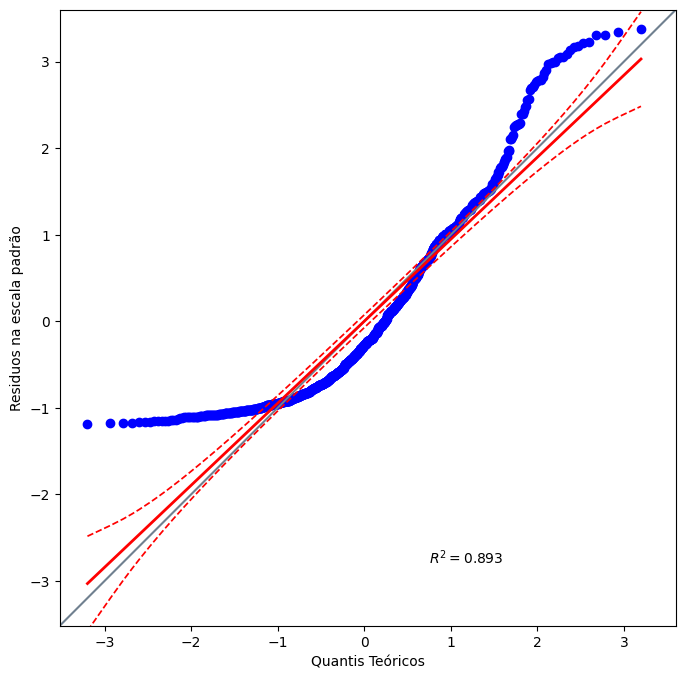

In [55]:
# Checar se residuos seguem distribuição normal
import pingouin as pg

plt.figure(figsize=(14,8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Residuos na escala padrão')

In [58]:
# Teste de normalidade Papiro Wilke
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors

stat_shapiro, p_value_shapiro = shapiro(residuos)
print(f'Estatística do teste: {stat_shapiro} e P-value Shapiro {p_value_shapiro}')

Estatística do teste: 0.891969217965228 e P-value Shapiro 7.013497918013492e-26


In [61]:
# Teste de normalidade Kolmogorov-Smirnov
stat_ks, p_value_ks = kstest(residuos, 'norm')
print(f'Estatística do teste: {stat_ks} e P-value Shapiro {p_value_ks}')

Estatística do teste: 0.5939999999999955 e P-value Shapiro 0.0


In [63]:
# Teste de normalidade Liliefors

stat_ll, p_value_ll = lilliefors(residuos, 'norm', pvalmethod='table')
print(f'Estatística do teste: {stat_ll} e P-value Shapiro {p_value_ll}')

Estatística do teste: 0.11825983774680088 e P-value Shapiro 0.0009999999999998899


# Treinar modelo polinomial

In [64]:
# Exemplo de criação de Features pólinomiais
feat_poly = PolynomialFeatures(degree=3, include_bias=False)

X_poly = feat_poly.fit_transform(X)

feat_poly.feature_names_in_


array(['tempo_na_empresa', 'nivel_na_empresa'], dtype=object)

In [70]:
feat_poly.get_feature_names_out(feat_poly.feature_names_in_)

array(['tempo_na_empresa', 'nivel_na_empresa', 'tempo_na_empresa^2',
       'tempo_na_empresa nivel_na_empresa', 'nivel_na_empresa^2',
       'tempo_na_empresa^3', 'tempo_na_empresa^2 nivel_na_empresa',
       'tempo_na_empresa nivel_na_empresa^2', 'nivel_na_empresa^3'],
      dtype=object)

In [76]:
# Bloco para treinamento do modelo

#graus_polynomial = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
graus_polynomial = [4]


rmse_train_values = []
rmse_test_values = []
percentual_rmse_values = []
r2score_test_values = []

#Slpit usando o Kfold usando 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=51)

for grau in graus_polynomial:
    # Padronização de variáveis numéricas - Tempo na empresa e Nível na empresa

    colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']
    transformer_numericas = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', transformer_numericas, colunas_numericas)
        ]
    )

    #Criar FEATURES polimoniais
    poly_feat = PolynomialFeatures(degree=grau, include_bias=False)

    #Criando o Pipeline principal que usa o transformer + treinamento
    model_poly = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('poly_feature', poly_feat),
        ('linear', LinearRegression())

    ]) 

    # Armazenar RMSE Treino 
    rmse_scores_fold_train = []
    rmse_scores_fold_test = []

    # Armazenar R2 score de teste
    r2_score_fold_test = []

    # Armazenar residuos
    residuos = []

    # Armazenar predições 
    y_pred_total = []

    # fazendo as iterações
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        #Treinar o modelo no conjunto de treinamentos
        model_poly.fit(X_train, y_train)

        # Faça predições nos conjuntos de treinamento e test
        y_train_pred = model_poly.predict(X_train)
        y_test_pred = model_poly.predict(X_test)

        #Calculo o RMSE do conjunto de treinamento e de teste
        rmse_train = root_mean_squared_error(y_train, y_train_pred)
        rmse_test = root_mean_squared_error(y_test, y_test_pred)
        # Calcular R2 Score e Residuos
        r2_score_test = r2_score(y_test, y_test_pred)
        residuos_test = np.array(y_test - y_test_pred)

        # Adicioanr os valores as listas
        rmse_scores_fold_train.append(rmse_train)
        rmse_scores_fold_test.append(rmse_test)
        r2_score_fold_test.append(r2_score_test)
        residuos.append(residuos_test)
        y_pred_total.append(y_test_pred)


    rmse_train_final = np.mean(rmse_scores_fold_train)
    rmse_test_final = np.mean(rmse_scores_fold_test)
    r2_score_final = np.mean(r2_score_fold_test)

    percentual_rmse_final = ((rmse_test_final - rmse_train_final)/rmse_train_final) * 100

    residuos = np.array(residuos).reshape(-1)
    y_pred_total = np.array(y_pred_total).reshape(-1)

    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_test_final)
    r2score_test_values.append(r2_score_final)
    percentual_rmse_values.append(percentual_rmse_final)



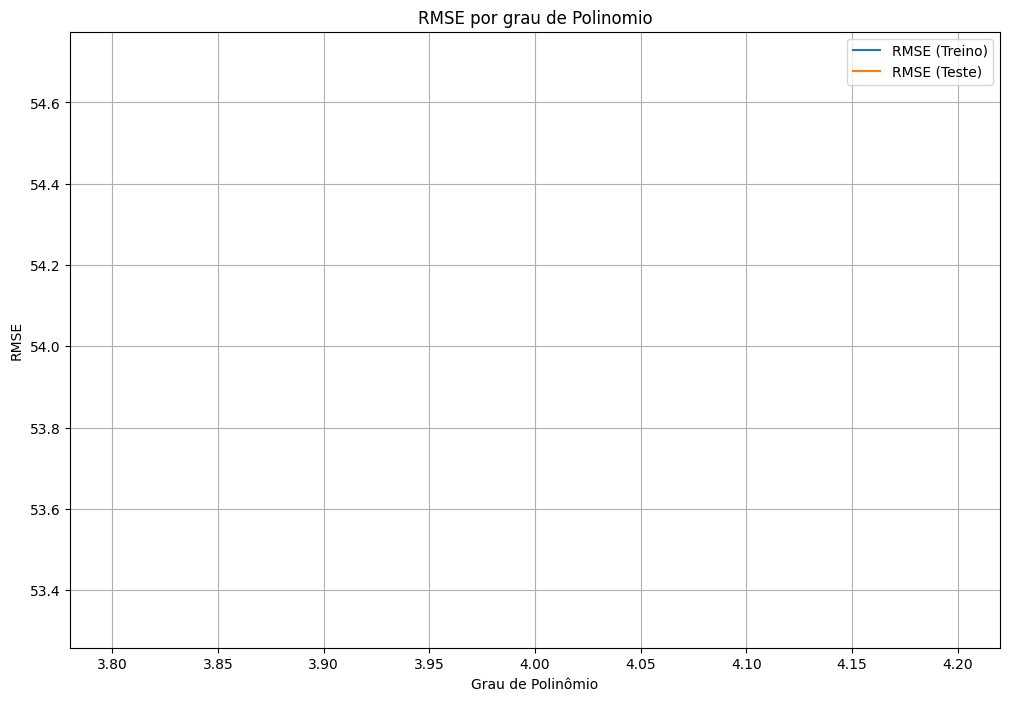

In [77]:
# Plotar grafico para comparar rmse por grau de polinomio
plt.figure(figsize=(12,8))

plt.plot(graus_polynomial, rmse_train_values, label='RMSE (Treino)')
plt.plot(graus_polynomial, rmse_test_values, label='RMSE (Teste)')
plt.xlabel('Grau de Polinômio')
plt.ylabel('RMSE')
plt.title('RMSE por grau de Polinomio')
plt.legend()
plt.grid(True)

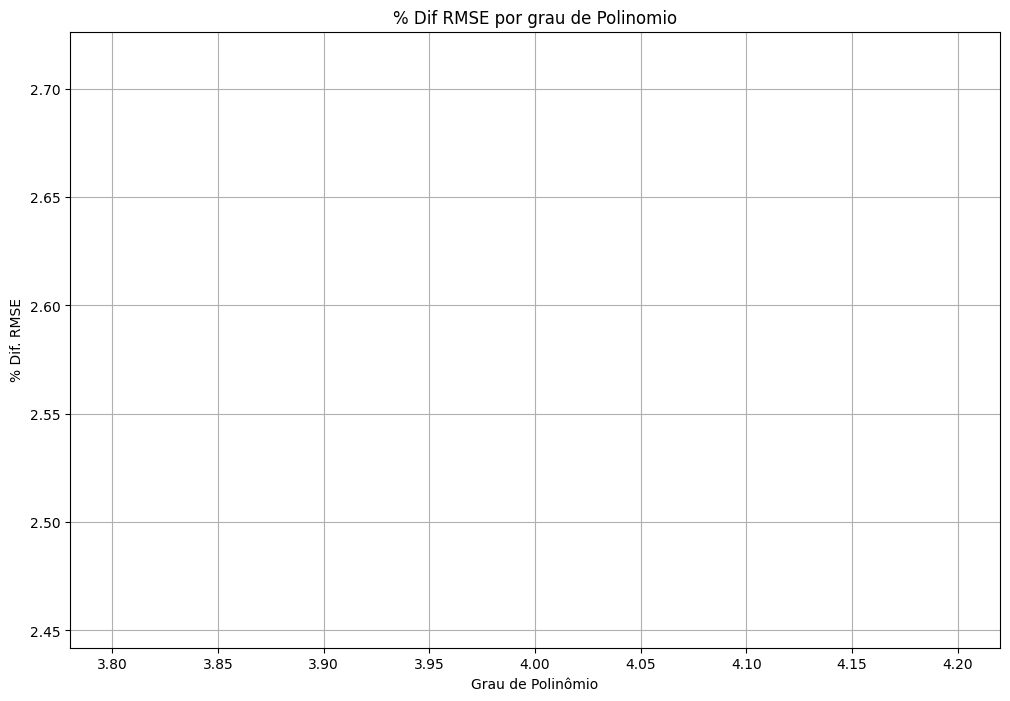

In [78]:
# Plotar grafico para comparar percentual de diferença RMSE TREINO E TESTE
plt.figure(figsize=(12,8))

plt.plot(graus_polynomial, percentual_rmse_values, label='% diferença RMSE Treino e teste')

plt.xlabel('Grau de Polinômio')
plt.ylabel('% Dif. RMSE')
plt.title('% Dif RMSE por grau de Polinomio')
plt.grid(True)

In [84]:
print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Teste: {rmse_test_final}')
print(f'Diferença Percentual RMSE: {percentual_rmse_final}')
print(f'R2 Score Test: {r2_score_final}')


RMSE Treino: 53.32698559565161
RMSE Teste: 54.70504352796304
Diferença Percentual RMSE: 2.5841661907546576
R2 Score Test: 0.9998524123039415


In [80]:
stat_shapiro, p_value_shapiro = shapiro(residuos)
print(f'Estatística do teste: {stat_shapiro} e P-value Shapiro {p_value_shapiro}')

Estatística do teste: 0.9986951372205322 e P-value Shapiro 0.6852797159659514


In [85]:
stat_ks, p_value_ks = kstest(residuos, 'norm')
print(f'Estatística do teste: {stat_ks} e P-value Shapiro {p_value_ks}')

Estatística do teste: 0.48237446499530856 e P-value Shapiro 1.2202460106524514e-214


In [86]:
stat_ll, p_value_ll = lilliefors(residuos, 'norm', pvalmethod='table')
print(f'Estatística do teste: {stat_ll} e P-value Shapiro {p_value_ll}')

Estatística do teste: 0.013637346894986191 e P-value Shapiro 0.9566270022044506


In [81]:
residuos_std = zscore(residuos)

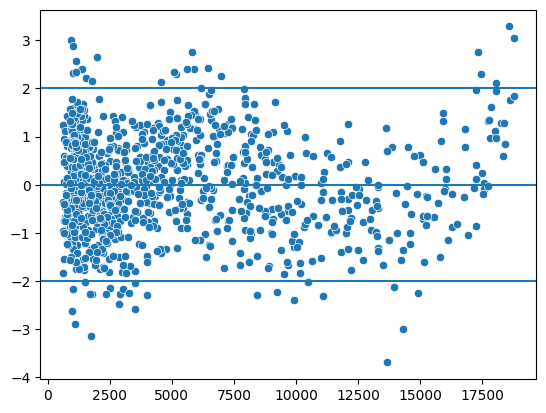

In [82]:
# Checar a Linearidade dos residuos - Valores entre -2 e 2 na escala padrão
# Verificar homocedasticidade - Se valroes estão em torno da reta sem nenhuma tendência ou formato
sns.scatterplot(x=y_pred_total, y=residuos_std)

plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)



Text(0, 0.5, 'Residuos na escala padrão')

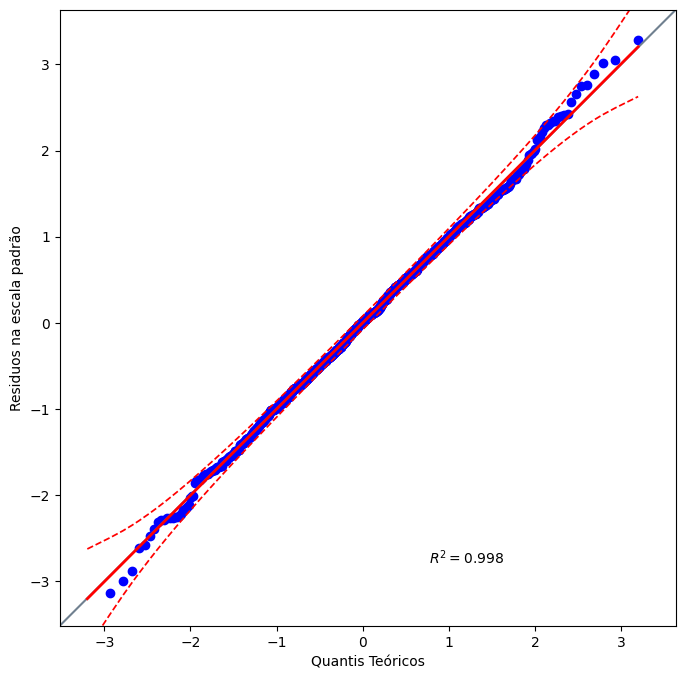

In [83]:
plt.figure(figsize=(14,8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Residuos na escala padrão')

# Realizar predições individuais

In [95]:
input_features = {
    'tempo_na_empresa': 120,
    'nivel_na_empresa': 6
}

df_pred = pd.DataFrame(input_features, index=[1])

In [96]:
# Realizar predição

model_poly.predict(df_pred)

array([18533.92084257])

In [97]:
import joblib 

In [98]:
joblib.dump(model_poly, './modelo_salario.pkl')

['./modelo_salario.pkl']